# VQE dimer noiseless

## Import section

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

from qiskit import *
from qiskit_aer import QasmSimulator, UnitarySimulator, StatevectorSimulator
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import *

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

#from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

# SciPy minimizer routine
from scipy.optimize import minimize

print("Imports Successful")

Imports Successful


In [57]:
Z = Pauli('Z').to_matrix();
ZI = Pauli('ZI').to_matrix();

display(ZI)

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

### Benchmark solution by exact diagonalization

(0.0, 6.5)

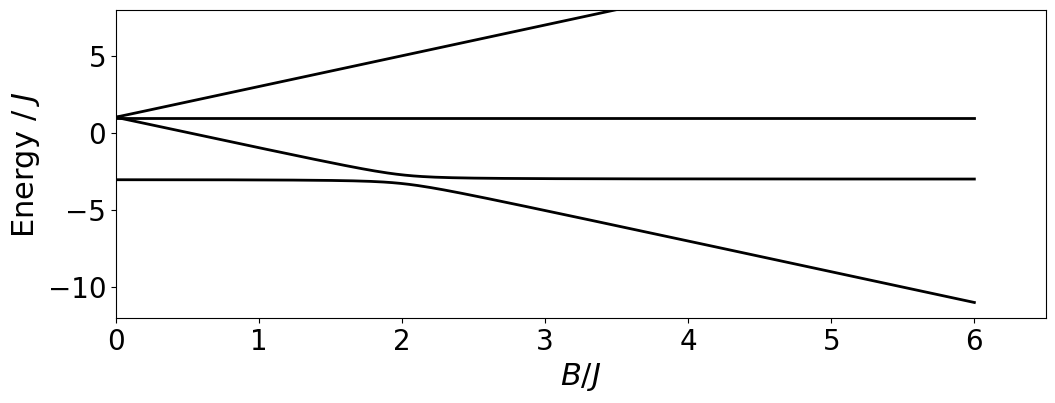

In [58]:
X = Pauli('X').to_matrix();
Y = Pauli('Y').to_matrix();
Z = Pauli('Z').to_matrix();
I = Pauli('I').to_matrix();

XX = Pauli('XX').to_matrix();
YY = Pauli('YY').to_matrix();
ZZ = Pauli('ZZ').to_matrix();
Z1 = Pauli('ZI').to_matrix();
Z2 = Pauli('IZ').to_matrix();

XZ = Pauli('XZ').to_matrix();
ZX = Pauli('ZX').to_matrix();

Jx = 1
Jy = 1
Jz = 1
D = 0.2

b_points = 200

B = np.linspace(0,6,b_points)

E = []
psi_0 = []
Magn_ex = []

for k in range(b_points):
    
    Ham = Jx*XX + Jy*YY + Jz*ZZ +\
          float(B[k])*(Z1 + Z2) +\
          D*(XZ - ZX)

    # diagonalizzo
    A,V = np.linalg.eig(Ham)
    
    imin = A.tolist().index(min(A)) # eigenvalues are not sorted, I need to locate the minimum
    psi_0.append(V[:,imin])         # save true ground state to check fidelity and observables
    
    As = np.sort(A)       
    
    E.append(np.real(As))
    Magn_ex.append(np.abs(V[0,imin])**2-np.abs(V[3,imin])**2)
    
# plot results

fig, ax = plt.subplots()

plt.plot(B, E, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("$B/ J$",size=22)
plt.ylabel("Energy / $J$",size=22)

plt.ylim([-12,8])
plt.xlim([0,6.5])

(0.0, 6.1)

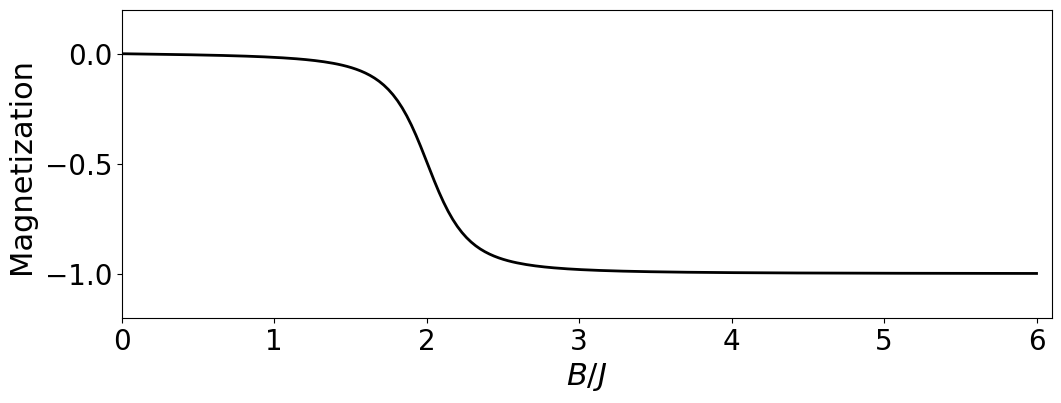

In [59]:
fig, ax = plt.subplots()

plt.plot(B, Magn_ex, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("$B/ J$",size=22)
plt.ylabel("Magnetization ",size=22)

plt.ylim([-1.2, 0.2])
plt.xlim([0,6.1])

In [60]:
hamiltonian = SparsePauliOp.from_list(
    [("XX", Jx), ("YY", Jy), ("ZZ", Jz), ("ZI", 1), ("IZ", 1), ("XZ", D), ("ZX", -D)]
)

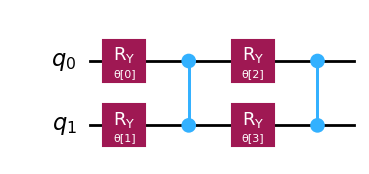

In [61]:
from qiskit.circuit.library import TwoLocal

#ansatz = EfficientSU2(hamiltonian.num_qubits)
#ansatz.decompose().draw("mpl", style="iqp")

qc = QuantumCircuit(hamiltonian.num_qubits)

ansatz_twolocal = TwoLocal(hamiltonian.num_qubits, rotation_blocks="ry", entanglement_blocks="cz", entanglement='full', reps=2, skip_final_rotation_layer=True)

raw_ansatz = qc.compose(ansatz_twolocal)
raw_ansatz.decompose().draw('mpl')


In [62]:
num_params = ansatz_twolocal.num_parameters
num_params

4

In [63]:
# setup the classical optimizer for the VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA, COBYLA

iterations = 125
lbfgsb = L_BFGS_B(maxiter=iterations)
cobyla = COBYLA(maxiter=iterations)
spsa = SPSA(maxiter=iterations) # this is gradient free

In [64]:
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [65]:
# define Aer Estimator for noiseless  simulation
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

shots = 1024
noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

In [66]:
# instantiate and run VQE
from qiskit_algorithms import VQE

algorithm_globals.random_seed = seed

estimator = noiseless_estimator #noiseless_estimator
ansatz = ansatz_twolocal #ansatz_UCCSD

vqe = VQE(estimator, ansatz, optimizer=spsa)
result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)

print(f"VQE on Aer qasm simulator: {result.eigenvalue.real:.5f}")
#print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")

VQE on Aer qasm simulator: -3.01367


In [67]:
X = Pauli('X').to_matrix();
Y = Pauli('Y').to_matrix();
Z = Pauli('Z').to_matrix();
I = Pauli('I').to_matrix();

XX = Pauli('XX').to_matrix();
YY = Pauli('YY').to_matrix();
ZZ = Pauli('ZZ').to_matrix();
Z1 = Pauli('ZI').to_matrix();
Z2 = Pauli('IZ').to_matrix();

XZ = Pauli('XZ').to_matrix();
ZX = Pauli('ZX').to_matrix();

Jx = 1
Jy = 1
Jz = 1
D = 0.2

b_points = 1

b = np.linspace(3,3,b_points)

E_ref = []
psi_0_ref = []
res = []
Magn_vqe = []
Magn_ref = []

#seed = 170
#algorithm_globals.random_seed = seed

shots = 1024
repetitions = 3;

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

for k in range(b_points):
    
    Ham = Jx*XX + Jy*YY + Jz*ZZ +\
          float(b[k])*(Z1 + Z2) +\
          D*(XZ - ZX)

    # diagonalizzo
    A,V = np.linalg.eig(Ham)
    
    imin = A.tolist().index(min(A)) # eigenvalues are not sorted, I need to locate the minimum
    psi_0_ref.append(V[:,imin])         # save true ground state to check fidelity and observables
    
    As = np.sort(A)       
    
    E_ref.append(np.real(A[imin]))
    Magn_ref.append(np.abs(V[0,imin])**2-np.abs(V[3,imin])**2)

    # VQE
    hamiltonian = SparsePauliOp.from_list(
    [("XX", Jx), ("YY", Jy), ("ZZ", Jz), ("ZI", float(b[k])), ("IZ", float(b[k])), ("XZ", D), ("ZX", -D)])
    qc = QuantumCircuit(hamiltonian.num_qubits)
    ansatz_twolocal = TwoLocal(hamiltonian.num_qubits, rotation_blocks="ry", entanglement_blocks="cz", entanglement='full', \
                               reps=repetitions, skip_final_rotation_layer=True)
    raw_ansatz = qc.compose(ansatz_twolocal)
    vqe = VQE(noiseless_estimator, ansatz_twolocal, optimizer=cobyla, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    res.append(result.eigenvalue.real)

 #   vqe.get_optimal_vector()

#    if not "00" in result.eigenstate: result.eigenstate["00"] = 0
 #   if not "01" in result.eigenstate: result.eigenstate["01"] = 0
 #   if not "10" in result.eigenstate: result.eigenstate["10"] = 0
 #   if not "11" in result.eigenstate: result.eigenstate["11"] = 0
        # estimated eigenstate (squared abs value of the components)
 #   prob_est = np.array([result.eigenstate['00'],result.eigenstate['01'],result.eigenstate['10'],result.eigenstate['11']])
        
 #   Magn_vqe.append(prob_est[0]-prob_est[3])

    print(np.around(b[k],2),np.around(res[k],2),np.around(E_ref[k],2) ) #, Magn_vqe[k], Magn_ref[k])


3.0 -5.02 -5.04


Text(0.5, 1.0, 'Convergence with no noise')

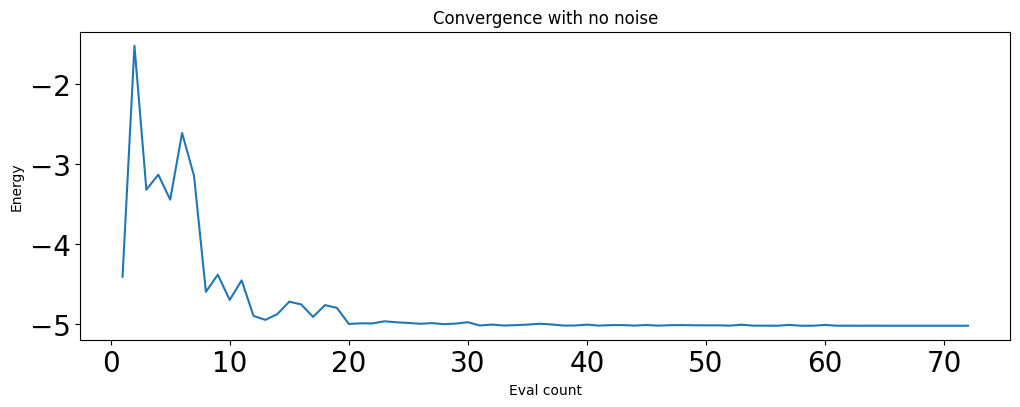

In [68]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

(0.0, 6.5)

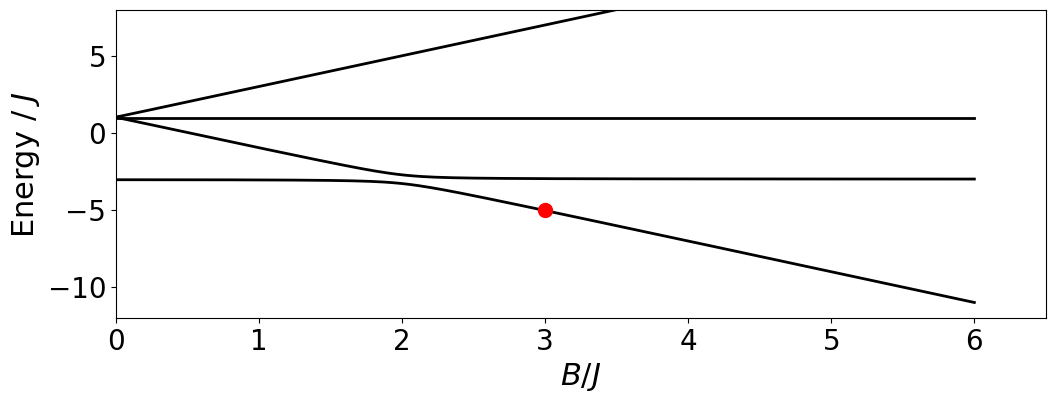

In [69]:
# plot results

fig, ax = plt.subplots()

plt.plot(B, E, linewidth=2.0, color = 'k')
plt.plot(b, res, color='r',lw=0, marker='o', markersize=10)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("$B/ J$",size=22)
plt.ylabel("Energy / $J$",size=22)

plt.ylim([-12,8])
plt.xlim([0,6.5])